<a href="https://colab.research.google.com/github/rezamohammadloo/Surface_anomaly_detection_using_unsupervised_algorithms/blob/main/Surface_anomaly_detction__using_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive to access files stored in my Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Define a function to load images from a specified directory and resize them to the target size
def load_images_from_directory(directory, target_size=(128, 128)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img = load_img(os.path.join(directory, filename), target_size=target_size)
            img_array = img_to_array(img) #/ 255.0
            images.append(img_array)
    return np.array(images)

# Directories
# Specify the directories containing normal, anomaly, and mask images
normal_dir = '/content/gdrive/MyDrive/glass-defect-sample/good'
anomaly_dir = '/content/gdrive/MyDrive/glass-defect-sample/anomaly'
mask_dir = '/content/gdrive/MyDrive/glass-defect-sample/mask'

# Load data
# Load the normal, anomaly, and mask images from their respective directories
good_images = load_images_from_directory(normal_dir)
anomaly_images = load_images_from_directory(anomaly_dir)
masks = load_images_from_directory(mask_dir)

# Normalize images
# Normalize the pixel values of the loaded images to the range [0, 1]
good_images = good_images / 255.0
anomaly_images = anomaly_images / 255.0
masks = masks / 255.0

# Split good images into training and validation sets
train_images, val_images = train_test_split(good_images, test_size=0.2, random_state=42)

In [4]:
# Image dimensions
img_height, img_width = 128, 128
img_channels = 3

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(img_channels, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

autoencoder = build_autoencoder((img_height, img_width, img_channels))
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928 

In [5]:
# Train the autoencoder
EarlyStopping = tf.keras.callbacks.EarlyStopping

history = autoencoder.fit(train_images, train_images,
                          epochs=500,
                          batch_size=32,
                          validation_data=(val_images, val_images),
                          verbose=1,
                          callbacks=EarlyStopping(  # Early stopping callback to prevent overfitting
        monitor="val_loss",  # Monitor validation loss
        verbose=1,  # Verbosity mode (1: progress bar, 0: silent)
        patience=6,  # Number of epochs with no improvement after which training will be stopped
        mode='min',  # Direction of improvement (minimize validation loss)
        restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
    ))


Epoch 1/500
4/4 [==============================] - 8s 610ms/step - loss: 0.5780 - val_loss: 0.5236
Epoch 2/500
4/4 [==============================] - 0s 44ms/step - loss: 0.5003 - val_loss: 0.4997
Epoch 3/500
4/4 [==============================] - 0s 46ms/step - loss: 0.4816 - val_loss: 0.5063
Epoch 4/500
4/4 [==============================] - 0s 46ms/step - loss: 0.4790 - val_loss: 0.5044
Epoch 5/500
4/4 [==============================] - 0s 45ms/step - loss: 0.4775 - val_loss: 0.4997
Epoch 6/500
4/4 [==============================] - 0s 46ms/step - loss: 0.4736 - val_loss: 0.4979
Epoch 7/500
4/4 [==============================] - 0s 44ms/step - loss: 0.4732 - val_loss: 0.5001
Epoch 8/500
4/4 [==============================] - 0s 46ms/step - loss: 0.4731 - val_loss: 0.4970
Epoch 9/500
4/4 [==============================] - 0s 45ms/step - loss: 0.4720 - val_loss: 0.4979
Epoch 10/500
4/4 [==============================] - 0s 46ms/step - loss: 0.4716 - val_loss: 0.4963
Epoch 11/500
4/4 [

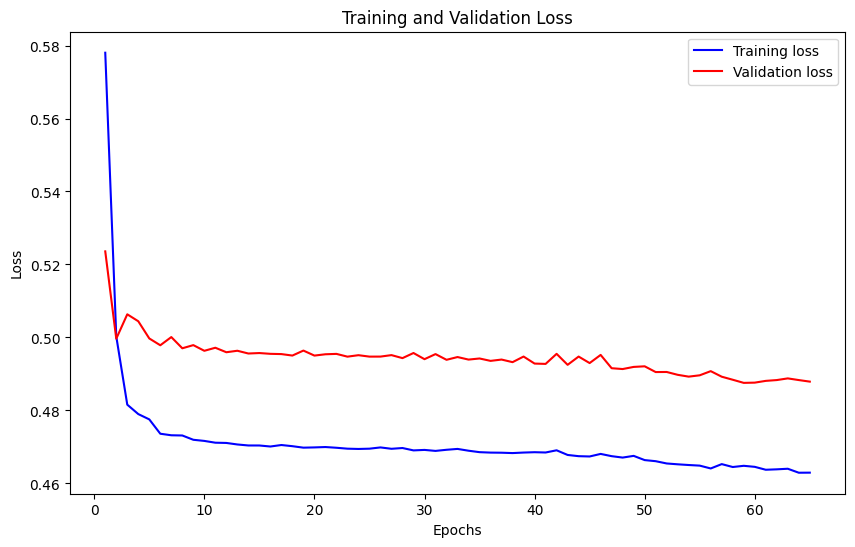

In [6]:
import matplotlib.pyplot as plt

# Extract the loss and validation loss from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss and validation loss
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training loss')  # Plot training loss
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # Plot validation loss
plt.title('Training and Validation Loss')  # Set plot title
plt.xlabel('Epochs')  # Set x-axis label
plt.ylabel('Loss')  # Set y-axis label
plt.legend()  # Display legend
plt.show()  # Show plot

In [7]:
def calculate_reconstruction_error(original, reconstructed):
    return np.mean(np.abs(original - reconstructed), axis=(1, 2, 3))

# Predict on anomaly images
reconstructed_anomalies = autoencoder.predict(anomaly_images)

# Calculate reconstruction error
reconstruction_errors = calculate_reconstruction_error(anomaly_images, reconstructed_anomalies)

# Threshold for anomaly detection (this can be tuned)
threshold = np.percentile(reconstruction_errors, 95)

# Detect anomalies
anomalies_detected = reconstruction_errors > threshold

2/2 [==============================] - 1s 370ms/step


In [8]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Function to calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    return np.mean(np.abs(original - reconstructed), axis=(1, 2, 3))

# Predict on both good and anomaly images
reconstructed_good = autoencoder.predict(good_images)
reconstructed_anomalies = autoencoder.predict(anomaly_images)

# Calculate reconstruction error for both
good_errors = calculate_reconstruction_error(good_images, reconstructed_good)
anomaly_errors = calculate_reconstruction_error(anomaly_images, reconstructed_anomalies)

# Combine errors and labels
all_errors = np.concatenate([good_errors, anomaly_errors])
all_labels = np.concatenate([np.zeros(len(good_errors)), np.ones(len(anomaly_errors))])

# Compute AUROC
auroc = roc_auc_score(all_labels, all_errors)
print(f'AUROC: {auroc:.4f}')

# Compute Average Precision (AP)
ap = average_precision_score(all_labels, all_errors)
print(f'Average Precision (AP): {ap:.4f}')


2/2 [==============================] - 0s 9ms/step
AUROC: 0.9358
Average Precision (AP): 0.8495
